In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox
import warnings
warnings.filterwarnings('ignore')
import scipy.io
from tensorsketch.sketch import Sketch
from plot_util import *

# data = scipy.io.loadmat('data/data_1.530E-02.mat').get('data') 

'''# For matlab
import hdf5storage
data= hdf5storage.loadmat('data/data_1.530E-020.mat')['data']
CO = data[:,:,:,15] 
T = data[:,:,:,39]
P = data[:,:,:,3]
pickle.dump(CO, open("data/CO.pickle",'wb'))
pickle.dump(T, open("data/T.pickle",'wb'))
pickle.dump(P, open("data/P.pickle",'wb'))'''

CO = pickle.load(open("data/CO.pickle", 'rb'))
T = pickle.load(open("data/T.pickle", 'rb'))
P = pickle.load(open("data/P.pickle", 'rb'))

Using numpy backend.
Using numpy backend.


In [2]:
def simrun_name(name, inv_factor,rm_typ): 
    ''' 
    Create an file name for a simulation run
    '''
    return "data/"+name+"_frk"+str(inv_factor)+"_"+rm_typ+".pickle"
def simplot_name(name, inv_factor): 
    return "plots/"+name+"_frk"+str(inv_factor)+".pdf" 
    '''
    Create an file name for simulation result plots 
    ''' 

def run_realdata_frk(data, inv_factor, name, random_seed = 1, rm_typ = "g"): 
    '''
    Run one pass, two pass, and HOOI on the same real world low-rank tensor data with 
    fixed rank = 1/inv_factor and varying k. 
    :param data: The dataset.
    :param inv_factor: The inverse of the increment between ks. 
    :param name: file name that store the simulation result. 
    '''
    ranks = (np.array(data.shape)/inv_factor).astype(int)
    _, _, _, hooi_rerr, _ = tensorsketch.tensor_approx.TensorApprox(data, ranks, rm_typ = rm_typ).tensor_approx('hooi')
    hooi_result = np.repeat(hooi_rerr, len(np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10))).tolist()
    one_pass_result = []
    two_pass_result = []
    for factor in np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10):  
        ks = (np.array(data.shape)*factor).astype(int)
        ss = 2*ks+1 
        sim = tensorsketch.tensor_approx.TensorApprox(data, ranks, ks, ss, rm_typ = rm_typ)
        _, _, _, two_pass_rerr, _ = sim.tensor_approx('twopass')
        _, _, _, one_pass_rerr, _ = sim.tensor_approx('onepass')
        one_pass_result.append(one_pass_rerr)
        two_pass_result.append(two_pass_rerr)
    result = [hooi_result, two_pass_result, one_pass_result] 
    pickle.dump( result, open(simrun_name(name,inv_factor,rm_typ), "wb" ) )
    return result


In [ ]:
run_realdata_frk(P, 10, "P", rm_typ = "gprod")
run_realdata_frk(P, 10, "P", rm_typ = "g")

run_realdata_frk(CO, 10, "CO", rm_typ = "gprod")
run_realdata_frk(T, 10, "T", rm_typ = "gprod")

run_realdata_frk(CO, 10, "CO", rm_typ = "g")
run_realdata_frk(T, 10, "T", rm_typ = "g")

'''
def multisimplotlog_name(name, inv_factor): 
    return "plots/"+"multi_"+name+"_frk"+str(inv_factor)+"log.pdf" 
def multiplot_realdata_frklog(rm_typs , data, inv_factor, name, label, fontsize = 18): 
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    sim_list = []
    ymaxs = [] 
    
    for i,rm_typ in enumerate(rm_typs):        
        sim_list.append(pickle.load(open(simrun_name(name, inv_factor, rm_typ), "rb" )))
        hooi_result = [np.log(sim_list[i][0][j]) for j in range(len(sim_list[i][0]))]
        two_pass_result = [np.log(sim_list[i][1][j]) for j in range(len(sim_list[i][0]))]
        one_pass_result = [np.log(sim_list[i][2][j]) for j in range(len(sim_list[i][0]))]
        plt.plot(kratio,two_pass_result, label = find_rm_label(rm_typ)+' 2-Pass', markersize = 10, marker = MARKER_LIST[2*i],markeredgewidth=1, markerfacecolor='None') 
        plt.plot(kratio,one_pass_result, label = find_rm_label(rm_typ)+' 1-Pass', markersize = 10, marker = MARKER_LIST[2*i+1],markeredgewidth=1, markerfacecolor='None') 
        if i == len(rm_typs)-1: 
            plt.plot(kratio,hooi_result, label = 'HOOI', markersize = 10, marker = MARKER_LIST[2*i+2],markeredgewidth=1, markerfacecolor ='None')
        alldata = np.concatenate([two_pass_result,one_pass_result])
        ymaxs.append(max(alldata)) 
    ymin = 0
    ymax = max(ymaxs)
    if name == 'P':
        plt.legend(loc = 'best')
    plt.title(label+", r/I = %s"%round(1/inv_factor,3))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    #plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig(multisimplotlog_name(name,inv_factor))
    plt.show()
    
'''

In [5]:
T[10,:,:]

array([[299.31712666, 299.36849798, 299.38467634, ..., 299.02337691,
        299.13238955, 299.23536323],
       [299.25323727, 299.30030888, 299.31565044, ..., 298.99031431,
        299.0876373 , 299.17953574],
       [299.18315596, 299.22419356, 299.23717831, ..., 298.9556626 ,
        299.03987422, 299.11920424],
       ...,
       [299.46184436, 299.51834824, 299.5309078 , ..., 299.10546177,
        299.23832193, 299.36476728],
       [299.42160916, 299.47740807, 299.4919198 , ..., 299.08121008,
        299.20812903, 299.32835476],
       [299.37340708, 299.42758873, 299.44339046, ..., 299.05382586,
        299.17276776, 299.28518715]])

# Todo: Check if m shares a similar internal structure 

In [6]:
hooi_result, twopass_result, onepass_result = pickle.load(open('data/experiment.pickle','rb'))

In [8]:
inv_factor = 5
ranks = (np.array(T.shape)/inv_factor).astype(int)    
ks = (np.array(T.shape)/inv_factor).astype(int)*2
ss = 2*ks+1 
rm_typ = 'gprod'
sim = tensorsketch.tensor_approx.TensorApprox(T, ranks, ks, ss, rm_typ = rm_typ)
X_hat_hooi, (hooi_core, hooi_factors), _, hooi_rerr, hooi_time = sim.tensor_approx('hooi')
X_hat_twopass, (twopass_core, twopass_factors), _, two_pass_rerr, two_pass_time = sim.tensor_approx('twopass')
X_hat_onepass, (onepass_core, onepass_factors), _, one_pass_rerr, one_pass_time = sim.tensor_approx('onepass')
print(hooi_rerr, two_pass_rerr, one_pass_rerr)
print(hooi_time, two_pass_time, one_pass_time)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


0.001089444572892098 0.0011289451378389877 0.0011829658547971372
(-1, 9.301079034805298) (1.21604585647583, 1.83198881149292) (2.4209158420562744, 1.3673992156982422)


In [26]:
tensorly.unfold(T,1).shape

(128, 180224)

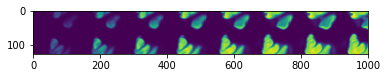

In [30]:

plt.imshow(tensorly.unfold(T,1)[:,range(1000)])

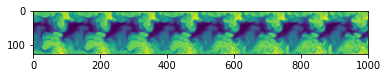

In [34]:
plt.imshow(tensorly.unfold(T,1)[:,range(5000,6000)])

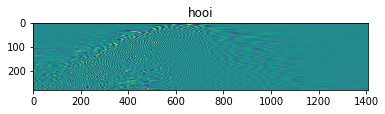

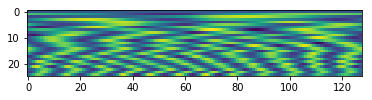

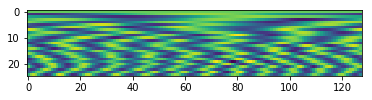

In [15]:
plt.figure()
plt.title('hooi')
plt.imshow(hooi_factors[0].T)
plt.figure()
plt.imshow(hooi_factors[1].T)
plt.figure()
plt.imshow(hooi_factors[2].T)

In [47]:
def plot_freq(A):
    freq = []
    for i in range(A.shape[1]): 
        data = np.fft.fft(A,axis=0)[range(int(A.shape[0]/2)),i]
        freq.append(np.argmax(data))
    plt.figure()
    plt.plot(freq)
    plt.ylabel('frequency')
    plt.show()
    return freq

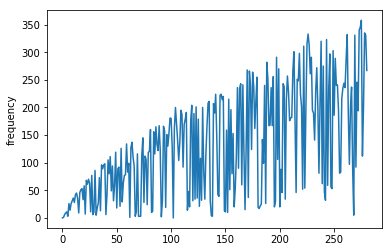

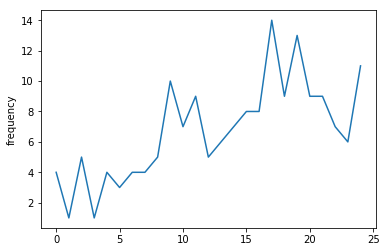

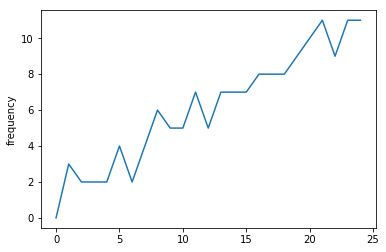

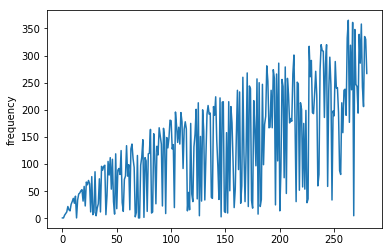

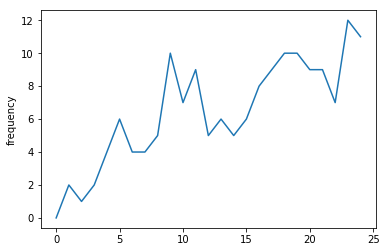

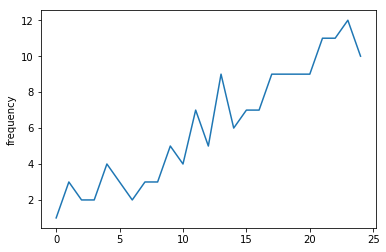

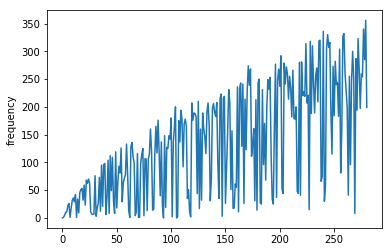

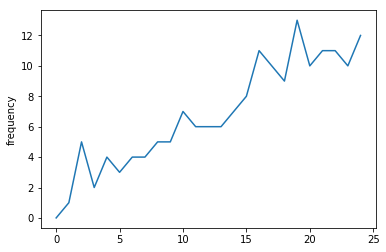

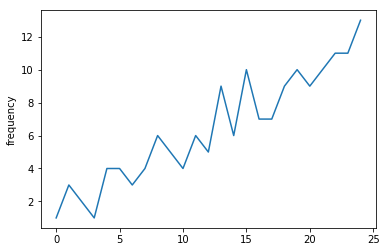

[1,
 3,
 2,
 1,
 4,
 4,
 3,
 4,
 6,
 5,
 4,
 6,
 5,
 9,
 6,
 10,
 7,
 7,
 9,
 10,
 9,
 10,
 11,
 11,
 13]

In [59]:
plot_freq(hooi_factors[0])
plot_freq(hooi_factors[1])
plot_freq(hooi_factors[2])
plot_freq(twopass_factors[0])
plot_freq(twopass_factors[1])
plot_freq(twopass_factors[2])
plot_freq(onepass_factors[0])
plot_freq(onepass_factors[1])
plot_freq(onepass_factors[2])

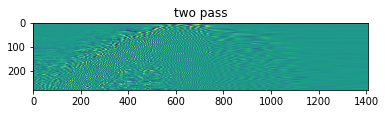

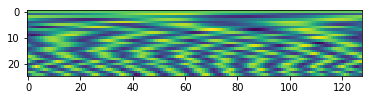

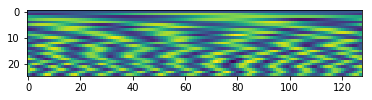

In [16]:
plt.figure()
plt.title('two pass')
plt.imshow(twopass_factors[0].T)
plt.figure()
plt.imshow(twopass_factors[1].T)
plt.figure()
plt.imshow(twopass_factors[2].T)

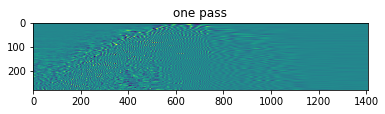

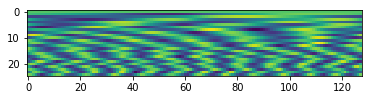

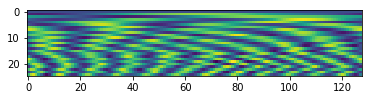

In [17]:
plt.figure()
plt.title('one pass')
plt.imshow(onepass_factors[0].T)
plt.figure()
plt.imshow(onepass_factors[1].T)
plt.figure()
plt.imshow(onepass_factors[2].T)

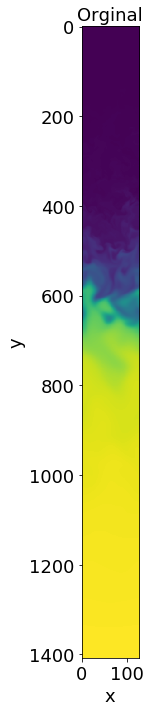

In [21]:
plt.figure(figsize=(5,10))
plt.imshow(T[:,100,:]) 
plt.title('Original', fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.savefig('plots/T100_original2.pdf')

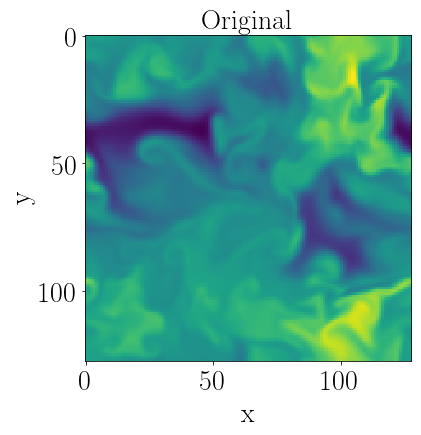

In [13]:
plt.figure(figsize=(6,6))
set_plot(fontsize = 28)
plt.imshow(T[100,:,:]) 
plt.title('Original', fontsize = 28)
plt.xticks(fontsize = 28)
plt.xlabel('x', fontsize = 28)
plt.ylabel('y', fontsize = 28)
plt.yticks(fontsize = 28)
plt.tight_layout()
plt.savefig('plots/T100_original.pdf',bbox_inches = "tight",pad_inches=0)

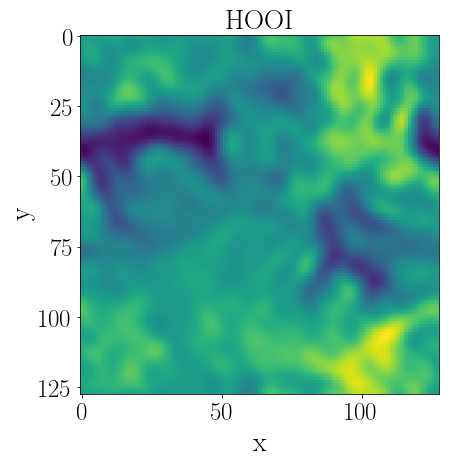

In [12]:
plt.figure(figsize=(6,6))
set_plot(fontsize = 28)
plt.imshow(X_hat_hooi[100,:,:])
plt.title('HOOI', fontsize = 28)
plt.xlabel('x', fontsize = 28)
plt.ylabel('y', fontsize = 28)
plt.savefig('plots/T100_hooi.pdf',bbox_inches = "tight",pad_inches=0)

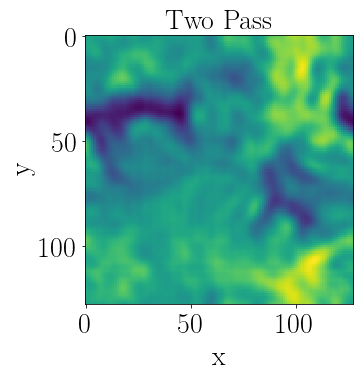

In [14]:
plt.figure(figsize=(5,5))
set_plot(fontsize = 28)
plt.imshow(X_hat_twopass[100,:,:]) 
plt.title('Two Pass', fontsize = 28)
plt.xticks(fontsize = 28)
plt.yticks(fontsize = 28)
plt.xlabel('x', fontsize = 28)
plt.ylabel('y', fontsize = 28)
plt.savefig('plots/T100_2pass.pdf',bbox_inches = "tight",pad_inches=0)

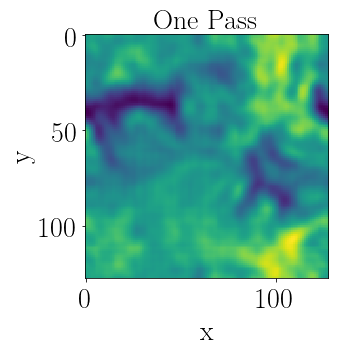

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(X_hat_onepass[100,:,:]) 
plt.title('One Pass', fontsize = 28)
plt.xticks(fontsize = 28)
plt.yticks(fontsize = 28)
plt.xlabel('x', fontsize = 28)
plt.ylabel('y', fontsize = 28)
plt.tight_layout()
plt.savefig('plots/T100_1pass.pdf',bbox_inches = "tight",pad_inches=0)

In [15]:
def multisimplot_name(name, inv_factor): 
    return "plots/"+"multi_"+name+"_frk"+str(inv_factor)+".pdf" 
def multiplot_realdata_frk(rm_typs , data, inv_factor, name, label, fontsize = 28): 
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)   
    plt.figure(figsize=(6,5))
    set_plot(fontsize)
    sim_list = []
    alldata = []
    for i,rm_typ in enumerate(rm_typs):        
        sim_list.append(pickle.load(open(simrun_name(name, inv_factor, rm_typ), "rb" )))
        hooi_result = np.array([(sim_list[i][0][j]) for j in range(len(sim_list[i][0]))])
        two_pass_result_diff = np.array([(sim_list[i][1][j]) for j in range(len(sim_list[i][0]))]) - hooi_result
        one_pass_result_diff = np.array([(sim_list[i][2][j]) for j in range(len(sim_list[i][0]))]) - hooi_result
        plt.plot(kratio,two_pass_result_diff, label = find_rm_label(rm_typ)+' 2-Pass', markersize = 10, marker = marker('2pass','gprod'), color = marker_color('2pass', 'gprod'), markeredgewidth=1, markerfacecolor='None') 
        plt.plot(kratio,one_pass_result_diff, label = find_rm_label(rm_typ)+' 1-Pass', markersize = 10, marker = marker('1pass','gprod'), color = marker_color('1pass', 'gprod'), markeredgewidth=1, markerfacecolor='None') 
        alldata.append(two_pass_result_diff)
        alldata.append(one_pass_result_diff)
    if name == 'P':
        plt.legend(loc = 'best',bbox_to_anchor=(1, 0.85))
    compression_ratio = int(np.product(data.shape)/(np.sum(np.array(data.shape)*ranks)+np.product(ranks)) )
    plt.title(''.join([label,'\n',r'$\times$',str(compression_ratio),' Compression' ]), fontsize = fontsize)
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    ymax = 10**np.ceil(np.log10(ymax))
    ymin = 10**np.floor(np.log10(ymin))
    plt.ylim(ymin, ymax)
    plt.xlabel('k/I')
    plt.ylabel('Regret')
    plt.yscale('log')
    plt.savefig(multisimplot_name(name,inv_factor),bbox_inches = "tight",pad_inches=0)
    plt.show()

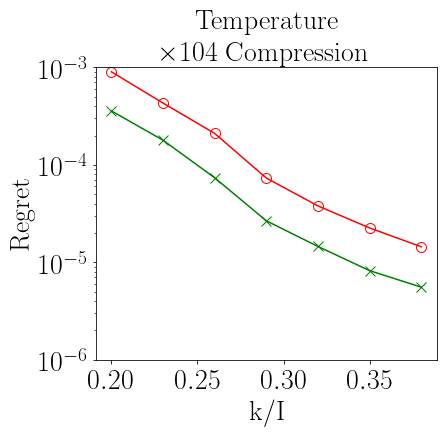

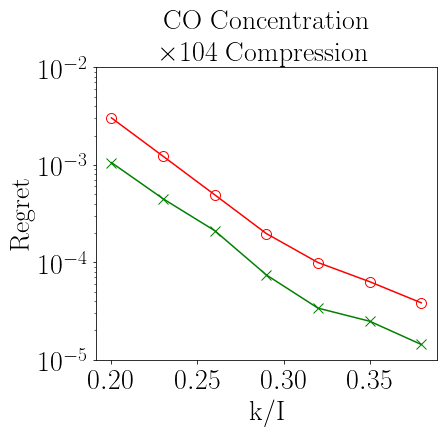

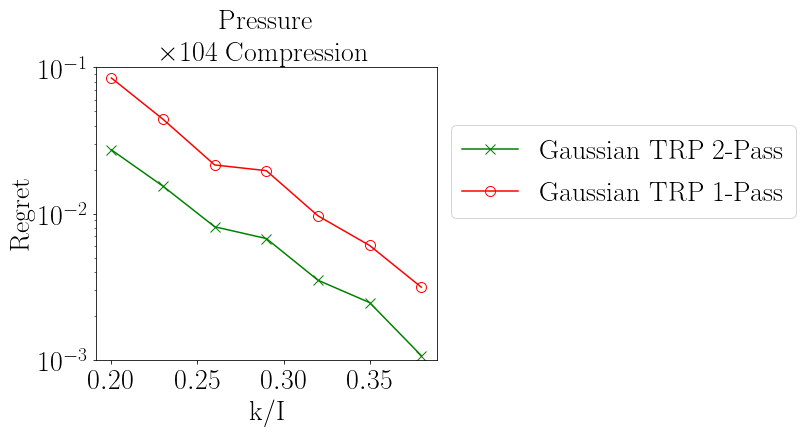

In [16]:
multiplot_realdata_frk(['gprod'], T,10,"T",label = "Temperature")
multiplot_realdata_frk(['gprod'], CO,10,"CO",label = "CO Concentration")
multiplot_realdata_frk(['gprod'], P,10, "P", label = "Pressure")

In [5]:
pressure = np.load("data/pressure.npy")[0]

In [4]:
def update_sketch(arm_sketches, core_sketch, data, ks, ss, rm_typ = 'g', ts_dim = 0, typ = 'turnstile', seed = 1):
    if typ == 'turnstile': 
        new_sketch = tensorsketch.sketch.Sketch(data, ks, seed, ss)
        [new_arm_sketches, new_core_sketch] = new_sketch.get_sketches()
        for i in range(len(arm_sketches)): 
            arm_sketches[i] = arm_sketches[i] + new_arm_sketches[i]
        core_sketch = core_sketch + new_core_sketch
        # print(new_core_sketch)
        # print(new_arm_sketches)
        return [arm_sketches, core_sketch]
    elif typ == "ts": 
        pass

In [6]:
ks = [352,32,32,10]
ss = [704, 64, 64, 15]
ranks = [200, 20, 20, 5]

In [7]:
def update_combustion(data, ks, ss, rm_typ = 'g', seed = 1):    
    np.random.seed(seed)
    # Initialize the arm sketches and core sketch 
    arms_sketches = [np.zeros([length,ks[i]]) for i, length in enumerate(list(data.shape))]
    core_sketch = np.zeros(ss)
    for i in np.arange(data.shape[3]): 
        print(i)
        new_data = np.zeros(data.shape)
        new_data[:,:,:,i] = data[:,:,:,i]
        sketches = update_sketch(arms_sketches, core_sketch, new_data, ks, ss, rm_typ= rm_typ, seed =  seed)
    return [arms_sketches, core_sketch] 
        

In [8]:
test = update_combustion(pressure[:,:,:,:5], ks, ss)

0


Using numpy backend.


1


Using numpy backend.


2


Using numpy backend.


3


Using numpy backend.


4


Using numpy backend.


## Generate some experiment for Ballester

In [1]:
def combustion_sim(data, ranks, ks, ss, seed = 1, rm_typ = 'g'):
    [arm_sketches, core_sketch] = update_combustion(data, ks, ss)
    tapprox = tensorsketch.tensor_approx.TensorApprox(data, ranks = ranks, ks = ks, \
            ss = ss, random_seed = seed, rm_typ = rm_typ, store_phis = False)
    
    _, _, _, hooi_rerr, _ = tapprox.tensor_approx('hooi')
    _, _, _, two_pass_rerr, _ = tapprox.tensor_approx('twopass')
    _, _, _, one_pass_rerr, _ = tapprox.tensor_approx('onepass')
    result = [hooi_result, two_pass_result, one_pass_result] 
    print(result)
    return result

In [47]:
inv_factor = 15

In [48]:
ranks = (np.array(new_data.shape)/inv_factor).astype(int)
ks = (np.array(new_data.shape)/inv_factor*2).astype(int)
ss = 2*ks + 1

In [73]:
new_data = data[:,:,:,3]

In [74]:
tapprox = tensorsketch.tensor_approx.TensorApprox(new_data, ranks = ranks, ks = ks, \
            ss = ss, random_seed = 1, rm_typ = 'g', store_phis = True)
    
_, _, _, hooi_rerr, _ = tapprox.tensor_approx('hooi')
print(hooi_rerr)

_, _, _, two_pass_rerr, _ = tapprox.tensor_approx('twopass')
print(two_pass_rerr)

_, _, _, one_pass_rerr, _ = tapprox.tensor_approx('onepass')
print(one_pass_rerr)

Using numpy backend.


0.3946050427412756


Using numpy backend.
Using numpy backend.


0.4390936871587023


Using numpy backend.
Using numpy backend.


0.5117884236179518
